In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import trange

In [2]:
accuracies = {}
categories = [
    "truck",
    "car",
    "plane",
    "ship",
    "cat",
    "dog",
    "horse",
    "deer",
    "frog",
    "bird",
]

In [3]:
model_architectures = ["resnet", "wide_resnet", "mobilenet", "efficientnet-b4", "efficientnet-b7", "clip", "vit", "resnext"]
for model_architecture in model_architectures:
    predictions = np.load(f"/cmlscratch/pkattaki/void/bg-var/logs/{model_architecture}/predictions.npy")
    accuracies[model_architecture] = {c: np.zeros((2, 4)) for c in (categories + ["total"])}
    for idx in trange(predictions.shape[0] - 2): # last 2 are not images (leftover from batch_size * num_batches)
        try:
            category = np.where(predictions[idx, 0:10])[0][0]
        except IndexError as e:
            print(model_architecture, predictions[idx, 0:10])
            raise e
        num_uncommon = int(np.sum(predictions[idx, 10:13]))
        accuracies[model_architecture][categories[category]][0, num_uncommon] += predictions[idx, 13]
        accuracies[model_architecture][categories[category]][1, num_uncommon] += 1
        accuracies[model_architecture]["total"][0, num_uncommon] += predictions[idx, 13]
        accuracies[model_architecture]["total"][1, num_uncommon] += 1

100%|██████████| 20813/20813 [00:00<00:00, 80615.00it/s]


In [4]:
arch_labels = ["ResNet50", "Wide-ResNet50-2", "MobileNet-v3-large", "EfficientNet-b4", "EfficientNet-b7", "CLIP", "ViT-B/16", "ResNeXt-50 (32x4d)"]

In [5]:
for idx in range(len(model_architectures)):
    correct_common = accuracies[model_architectures[idx]]["total"][0, 0]
    total_common = accuracies[model_architectures[idx]]["total"][1, 0]
    correct_uncommon = np.sum(accuracies[model_architectures[idx]]["total"][0, 1:3])
    total_uncommon = np.sum(accuracies[model_architectures[idx]]["total"][1, 1:3])
    print(f"{model_architectures[idx]}: {100 * (correct_common / total_common - correct_uncommon / total_uncommon)} ")

resnet: 29.756346616680556 
wide_resnet: 27.533856676522323 
mobilenet: 28.585486193922165 
efficientnet-b4: 24.20037700584261 
efficientnet-b7: 23.51077927699823 
clip: 21.65057636495309 
vit: 26.174901715754338 
resnext: 26.012543833140032 


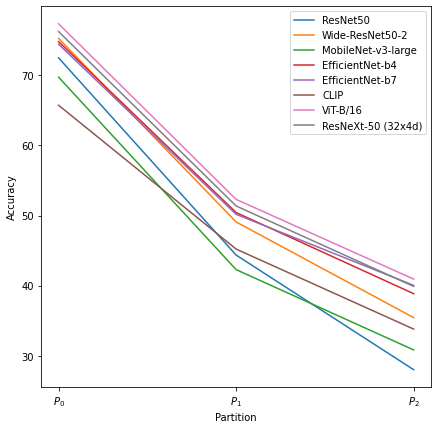

In [12]:
for idx in range(len(model_architectures)):
    plt.plot(range(3), 100 * accuracies[model_architectures[idx]]["total"][0, :3] / accuracies[model_architectures[idx]]["total"][1, :3], label=arch_labels[idx])
plt.xticks(range(3))
plt.gca().set_xticklabels(["$P_0$", "$P_1$", "$P_2$"])
plt.xlabel("Partition")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
fig = plt.gcf()
fig.set_size_inches(7, 7)
fig.savefig("../../logs/all_accuracy_plots.pdf")

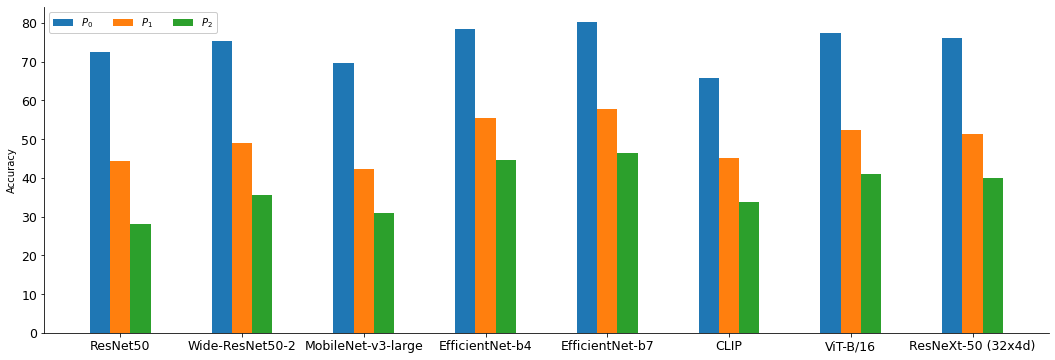

In [13]:
labels = ["$P_0$", "$P_1$", "$P_2$"]
acc = np.zeros((len(labels), len(arch_labels)))
for idx in range(8):
    acc[:, idx] = 100 * accuracies[model_architectures[idx]]["total"][0, :3] / accuracies[model_architectures[idx]]["total"][1, :3]
labels = ["$P_0$", "$P_1$", "$P_2$"]
arch_labels = ["ResNet50", "Wide-ResNet50-2", "MobileNet-v3-large", "EfficientNet-b4", "EfficientNet-b7", "CLIP", "ViT-B/16", "ResNeXt-50 (32x4d)"]
width = 0.5
x = np.arange(len(arch_labels))
fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
offsets = np.zeros((len(labels), len(arch_labels)))
for i in range(len(labels)):
    for idx in range(len(arch_labels)):
        offsets[i, idx] = (5 - i - len(arch_labels) // 2) * width / 3
for idx in range(len(labels)):
    ax.bar(x - offsets[idx], acc[idx], width / 3, label=labels[idx])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(x)
ax.set_xticklabels(arch_labels)
# plt.xticks(rotation=45)
ax.set_ylabel("Accuracy")
ax.legend(loc="upper left", ncol=3, framealpha=1.0)
plt.tick_params(labelsize=12.5)
# fig.tight_layout()
plt.gcf().savefig("../../logs/all_accuracy_plots.pdf")

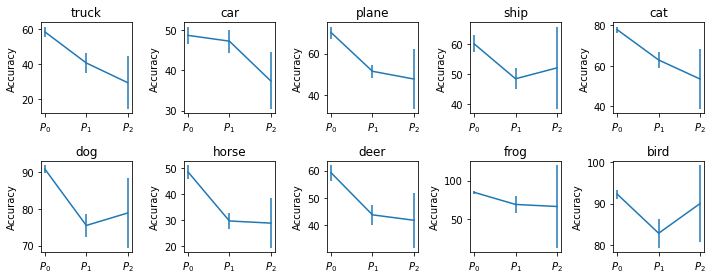

In [8]:
num_rows = 2
num_cols = 5
fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 4))
for cat_idx, category in enumerate(categories):
    i = cat_idx // num_cols
    j = cat_idx % num_cols
    
    for idx in range(4, len(model_architectures)):
        n = accuracies[model_architectures[idx]][category][0, :3]
        N = accuracies[model_architectures[idx]][category][1, :3]
        p = n / N
        yerr = 100 * 1.96 * np.sqrt(p * (1 - p) / N)
        ax[i, j].errorbar(range(3), 100 * p, yerr=yerr, label=arch_labels[idx])
        break
    ax[i, j].set_title(category)
    ax[i, j].set_xticks(range(3))
    ax[i, j].set_xticklabels(["$P_0$", "$P_1$", "$P_2$"])
    ax[i, j].set_ylabel("Accuracy")

# plt.legend(arch_labels, loc="lower right")
plt.tight_layout()
plt.gcf().savefig("../../logs/efficientnet_b7_classwise_accuracy_plots.pdf")

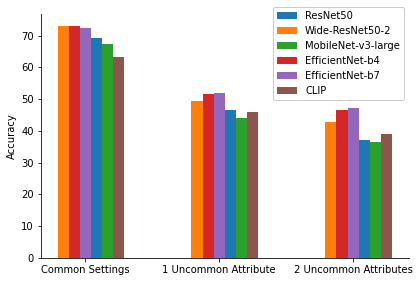

In [35]:
labels = ["Common Settings", "1 Uncommon Attribute", "2 Uncommon Attributes"]
width = 0.5
x = np.arange(len(labels))
fig, ax = plt.subplots()
data = np.zeros((len(model_architectures), 3))
offsets = np.zeros((len(model_architectures), 3))
for idx in range(len(model_architectures)):
    data[idx] = 100 * accuracies[model_architectures[idx]]["total"][0, :3] / accuracies[model_architectures[idx]]["total"][1, :3]
sorted_idxs = np.argsort(data, axis=0)
for i in range(3):
    for idx in range(len(model_architectures)):
        offsets[idx, i] = (np.where(sorted_idxs[:, i] == idx)[0][0] - len(model_architectures) // 2) * width / 6
for idx in range(len(model_architectures)):
    ax.bar(x - offsets[idx][0], data[idx], width / 6, label=arch_labels[idx])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#     plt.plot(range(3), 100 * accuracies[model_architectures[idx]]["total"][0, :3] / accuracies[model_architectures[idx]]["total"][1, :3], label=arch_labels[idx])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Accuracy")
ax.legend(loc="upper right", framealpha=1.0, bbox_to_anchor=(1, 1.05))
fig.tight_layout()
plt.gcf().savefig("../../logs/accuracy_bar_plots.pdf")

In [6]:
finetuned = np.array([
    [[73, 44, 25, 43], [90, 83, 77, 100]], # "resnet"
    [[75, 51, 30, 43], [89, 80, 74, 86]], # "wide_resnet"
    [[69, 43, 29, 43], [86, 77, 69, 86]], # "mobilenet"
    [[75, 52, 35, 43], [78, 60, 45, 43]], # "efficientnet-b4"
    [[80, 59, 43, 57], [80, 62, 53, 57]], # "efficientnet-b7"
    [[77, 54, 37, 57], [95, 94, 93, 100]], # "vit"
    [[76, 53, 36, 43], [75, 54, 42, 43]], # "resnext"
])
finetuned.shape

(7, 2, 4)

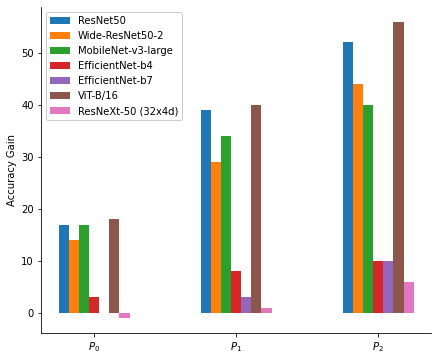

In [7]:
labels = ["$P_0$", "$P_1$", "$P_2$"]
arch_labels = ["ResNet50", "Wide-ResNet50-2", "MobileNet-v3-large", "EfficientNet-b4", "EfficientNet-b7", "ViT-B/16", "ResNeXt-50 (32x4d)"]
width = 0.5
x = np.arange(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(7, 6)
offsets = np.zeros((len(model_architectures) - 1, 3))
for i in range(3):
    for idx in range(len(model_architectures) - 1):
        offsets[idx, i] = (7 - idx - len(model_architectures) // 2) * width / 7
for idx in range(len(model_architectures) - 1):
    ax.bar(x - offsets[idx][0], finetuned[idx][1][:3] - finetuned[idx][0][:3], width / 7, label=arch_labels[idx])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Accuracy Gain")
ax.legend(loc="upper left", framealpha=1.0)
# fig.tight_layout()
plt.gcf().savefig("../../logs/finetuned_accuracies.pdf")